In [1]:
import pandas as pd
import numpy as np

import sys
import os

from pathlib import Path
# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Data Loading


In [2]:
Emofilm = 'D:/Documents/emofilm/data/wav_corpus/'
Emofilm_uk = 'D:/Documents/emofilm/data/wav_corpus_uk/'

In [3]:
fear_label = 'fear'
contempt_label = 'contempt'
happiness_label = 'happiness'
anger_label = 'anger'
sadness_label = 'sadness'
neutral_label = 'neutral'
surprise_label = 'surprise'

In [4]:
# emofilm_info_df = pd.read_csv('D:/Documents/emofilm/data/complete_info.csv')
emofilm_uk_df = pd.read_csv('D:/Documents/emofilm/data/emofilm_uk_df.csv')
emofilm_df = pd.read_csv('D:/Documents/emofilm_df.csv')
ravdess_df = pd.read_csv('D:/Documents/ravdess_df.csv')

In [5]:
emofilm_df.head(2)

,emotion,path
0,fear,D:/Documents/emofilm/data/wav_corpus/f_ans001a...
1,fear,D:/Documents/emofilm/data/wav_corpus/f_ans001a...


In [6]:
emofilm_uk_df.head(2)

,emotion,path
0,fear,D:/Documents/emofilm/data/wav_corpus_uk/f_ans1...
1,fear,D:/Documents/emofilm/data/wav_corpus_uk/f_ans1...


In [7]:
ravdess_df.head(2)

,emotion,path
0,neutral,D:/Documents/ravdess/Actor_01/03-01-01-01-01-0...
1,neutral,D:/Documents/ravdess/Actor_01/03-01-01-01-01-0...


In [8]:
# emofilm_emotions = {
#     'ans': fear_label,
#     'dis': contempt_label,
#     'gio': happiness_label,
#     'rab': anger_label,
#     'tri': sadness_label
# }

# # file_emotion = []
# # file_path = []
# emofilm_map = {'emotion': [], 'path': []}
# for index, row in emofilm_info_df.iterrows():
#     emofilm_map['emotion'].append(emofilm_emotions.get(row.emotion))
#     emofilm_map['path'].append(os.path.join(Emofilm, row.file) + '.wav')


# emofilm_df = pd.DataFrame(emofilm_map)
# emofilm_df.head(2)

In [9]:
# emofilm_df.to_csv('D:/Documents/emofilm_df.csv', index=False)

In [8]:
data_df = pd.concat([emofilm_df, emofilm_uk_df, ravdess_df],
                    axis=0, ignore_index=True)


data_df.head()

,emotion,path
0,fear,D:/Documents/emofilm/data/wav_corpus/f_ans001a...
1,fear,D:/Documents/emofilm/data/wav_corpus/f_ans001a...
2,fear,D:/Documents/emofilm/data/wav_corpus/f_ans001a...
3,fear,D:/Documents/emofilm/data/wav_corpus/f_ans002a...
4,fear,D:/Documents/emofilm/data/wav_corpus/f_ans002a...


In [9]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2581 entries, 0 to 2580
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  2581 non-null   object
 1   path     2581 non-null   object
dtypes: object(2)
memory usage: 40.5+ KB


In [10]:
emotions_number = data_df.emotion.unique().size
emotions_number

8

## Data Preparation


In [11]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data


def invert_polarity(data):
    return data * -1


def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)


def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5)*1000)
    return np.roll(data, shift_range)


def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


# taking any example and checking for techniques.
path = np.array(data_df.path)[1]
data, sample_rate = librosa.load(path)

feature extraction functions


In [12]:
def extract_zcr(data):
    return librosa.feature.zero_crossing_rate(y=data)


def extract_chroma_stft(data, sr):
    return librosa.feature.chroma_stft(y=data, sr=sr)


def extract_mfcc(data, sr):
    return librosa.feature.mfcc(y=data, sr=sr)


def extract_rms(data):
    return librosa.feature.rms(y=data)


def extract_melspectrogram(data, sr):
    return librosa.feature.melspectrogram(y=data, sr=sr, n_fft=512)

In [13]:
# This code was adapted from Nicolas Gervais on https://stackoverflow.com/questions/59241216/padding-numpy-arrays-to-a-specific-size on 1/10/2021
import math
from numpy import ndarray


def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """
    h = array.shape[0]
    w = array.shape[1]
    a = max((xx - h) // 2, 0)
    aa = max(0, xx - a - h)
    b = max(0, (yy - w) // 2)
    bb = max(yy - b - w, 0)
    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')


def fix_length(data: ndarray, length: int):
    fixed = data.reshape(len(data), 1)
    fixed = padding(fixed, length, 1)
    fixed = fixed.reshape(len(fixed))

    return fixed


def repeat_audio(data: ndarray, sr: int, duration_millis: int):

    length = int(duration_millis/1000*sr)
    n = math.ceil(duration_millis/1000*sr/len(data))
    fixed = np.tile(data, n)
    fixed = fixed[:length]

    return fixed

In [14]:
max_length = 110250
max_i = 14
sample_rate = 22050
max_duration_s = librosa.get_duration(path=data_df['path'][14])
required_duration_millis = 5000

width = 216  # 5 seconds of adio is 216
height = 128  # melspectrogram height is 128

duration = int(required_duration_millis/1000*sample_rate)

In [24]:
a, sr = librosa.load(data_df['path'][2])
print(a.shape, sr)

(54860,) 22050


In [25]:
width2 = int(required_duration_millis/1000*sr)
width2

110250

In [26]:
repeated_audio = repeat_audio(a, sr, required_duration_millis)

print('Array length before padding', np.shape(a))
print('Audio length before padding in seconds', (np.shape(a)[0]/sr))
print('Array length after padding', np.shape(repeated_audio))
print('Audio length after padding in seconds',
      (np.shape(repeated_audio)[0]/sr))
Audio(data=repeated_audio, rate=sr)

Array length before padding (54860,)
Audio length before padding in seconds 2.487981859410431
Array length after padding (110250,)
Audio length after padding in seconds 5.0


In [18]:
required_audio_size = 5  # audio of size 2 second needs to be padded to 5 seconds
# mono=True converts stereo audio to mono
# padded_audio = librosa.util.fix_length(
#     a, size=int(required_duration_millis/1000*sr))

padded_audio = fix_length(a, width2)

print('Array length before padding', np.shape(a))
print('Audio length before padding in seconds', (np.shape(a)[0]/sr))
print('Array length after padding', np.shape(padded_audio))
print('Audio length after padding in seconds', (np.shape(padded_audio)[0]/sr))
Audio(data=padded_audio, rate=sr)

Array length before padding (54860,)
Audio length before padding in seconds 2.487981859410431
Array length after padding (110250,)
Audio length after padding in seconds 5.0


(20, 216)


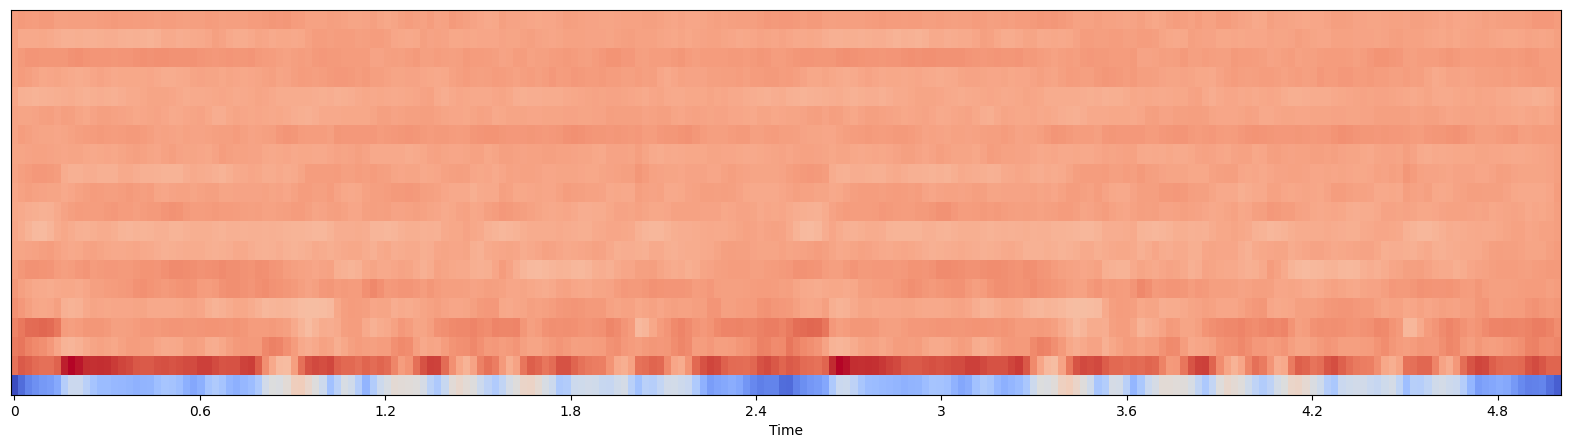

In [19]:
# MFCC
plt.figure(figsize=(20, 5))
mfccs = librosa.feature.mfcc(y=repeated_audio, sr=sr)
print(mfccs.shape)

librosa.display.specshow(mfccs, sr=sr, x_axis='time')

(12, 216)


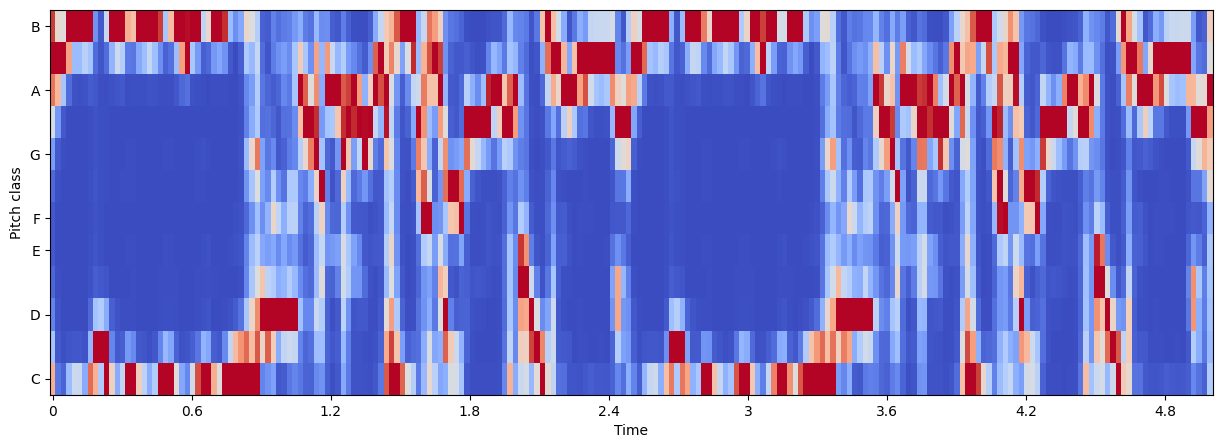

In [27]:
hop_length = 512
S = np.abs(librosa.stft(a))
chromagram = librosa.feature.chroma_stft(
    y=repeated_audio, sr=sr, hop_length=hop_length)
print(chromagram.shape)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time',
                         y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
plt.show()

In [28]:
print(mfccs.shape, chromagram.shape)

(20, 216) (12, 216)


## Feature extraction


get features from all files


In [29]:
def extract_features(data):
    result = np.array([])

    # ZCR
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))  # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(
        S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))  # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))  # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))  # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(
        y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))  # stacking horizontally

    return result


def get_features(path):

    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))  # stacking vertically

    invert_data = noise(data)
    res3 = extract_features(invert_data)
    result = np.vstack((result, res3))  # stacking vertically

    return result

In [32]:
features_df = pd.read_csv('ser3-features.csv')
features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.174738,0.648226,0.677165,0.692260,0.716191,0.665501,0.607874,0.632416,0.642000,0.712695,...,0.008625,0.008645,0.009090,0.010604,0.011772,0.008924,0.003265,0.001107,0.000084,fear
1,0.174697,0.648299,0.677025,0.692344,0.716473,0.665811,0.608228,0.632571,0.642032,0.712725,...,0.008626,0.008645,0.009090,0.010605,0.011772,0.008924,0.003265,0.001107,0.000084,fear
2,0.264561,0.724794,0.750835,0.766878,0.782325,0.749098,0.670869,0.661657,0.683045,0.743842,...,0.012753,0.012722,0.012413,0.014256,0.015697,0.012556,0.007289,0.005213,0.004063,fear
3,0.181625,0.643610,0.581965,0.477430,0.558267,0.605189,0.522657,0.561186,0.614690,0.624254,...,0.183382,0.144932,0.060404,0.048087,0.056380,0.072826,0.076891,0.034622,0.004218,fear
4,0.235465,0.680034,0.597814,0.549955,0.624712,0.624618,0.555420,0.602183,0.640614,0.653247,...,0.186045,0.146982,0.063690,0.050840,0.059962,0.075606,0.079566,0.037372,0.007272,fear


In [33]:
# X, y = [], []
# for i, row in data_df.iterrows():
#     features = get_features(row['path'])
#     for f in features:
#         X.append(f)
#         y.append(row['emotion'])


# features_df = pd.DataFrame(X)
# features_df['labels'] = y
# features_df.to_csv('ser3-features.csv', index=False)
# features_df.head()

In [34]:
X = features_df.iloc[:, :-1].values
y = features_df['labels'].values

In [35]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1, 1)).toarray()

In [36]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, shuffle=True)

print(
    f'train:\t {x_train.shape, y_train.shape,}\ntest:\t{x_test.shape, y_test.shape}')

train:	 ((6194, 162), (6194, 8))
test:	((1549, 162), (1549, 8))


In [37]:
# Split once to get the test and validation set
x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test, test_size=0.3, random_state=42)
print(
    f'val:\t {x_val.shape, y_val.shape,}\ntest:\t{x_test.shape, y_test.shape}')

val:	 ((1084, 162), (1084, 8))
test:	((465, 162), (465, 8))


scale data


In [31]:
# # scaling our data with sklearn's Standard scaler
# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)
# x_val = scaler.fit_transform(x_val)
# print(
#     f'train:\t {x_train.shape, y_train.shape,}\ntest:\t{x_val.shape, y_val.shape}\ntest: {x_test.shape, y_test.shape}')

In [32]:
y_val.shape

(1084, 8)

## Modeling


In [33]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, AveragePooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import metrics

print(tf.config.list_physical_devices('GPU'))

[]


### main


In [34]:
model = Sequential()
model.add(Conv1D(64, kernel_size=7, padding='same',
          activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Dropout(0.2))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
model.add(AveragePooling1D(pool_size=2, padding='same'))
model.add(Dropout(0.2))
model.add(Conv1D(256, kernel_size=3, activation='relu'))
model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
model.add(AveragePooling1D(pool_size=2, padding='same'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=emotions_number, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 64)           512       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 64)            12352     
                                                                 
 conv1d_2 (Conv1D)           (None, 81, 64)            12352     
                                                                 
 conv1d_3 (Conv1D)           (None, 81, 64)            12352     
                                                                 
 conv1d_4 (Conv1D)           (None, 81, 64)            12352     
                                                        

In [35]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4,
                         verbose=0, patience=2, min_lr=0.0000001)


history = model.fit(x_train, y_train, batch_size=64, epochs=30,
                    validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/30


97/97 [==============================] - 15s 131ms/step - loss: 1.7826 - accuracy: 0.2735 - val_loss: 1.6108 - val_accuracy: 0.3441 - lr: 0.0010
Epoch 2/30
97/97 [==============================] - 12s 124ms/step - loss: 1.6154 - accuracy: 0.3468 - val_loss: 1.5724 - val_accuracy: 0.3548 - lr: 0.0010
Epoch 3/30
97/97 [==============================] - 12s 128ms/step - loss: 1.5423 - accuracy: 0.3820 - val_loss: 1.5129 - val_accuracy: 0.3677 - lr: 0.0010
Epoch 4/30
97/97 [==============================] - 13s 138ms/step - loss: 1.5080 - accuracy: 0.3954 - val_loss: 1.4677 - val_accuracy: 0.3935 - lr: 0.0010
Epoch 5/30
97/97 [==============================] - 13s 137ms/step - loss: 1.4681 - accuracy: 0.4191 - val_loss: 1.4730 - val_accuracy: 0.4065 - lr: 0.0010
Epoch 6/30
97/97 [==============================] - 13s 136ms/step - loss: 1.4390 - accuracy: 0.4364 - val_loss: 1.4565 - val_accuracy: 0.4108 - lr: 0.0010
Epoch 7/30
97/97 [==============================] - 13s 136ms/step - loss: 

In [36]:
def print_report(model, history, test_x, test_y):
    print("Accuracy of our model on test data : ",
          model.evaluate(test_x, test_y)[1]*100, "%")

    epochs = history.epoch

    fig, ax = plt.subplots(1, 2)

    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    test_acc = history.history['val_accuracy']
    test_loss = history.history['val_loss']

    fig.set_size_inches(20, 6)
    ax[0].plot(epochs, train_loss, label='Training Loss')
    ax[0].plot(epochs, test_loss, label='Testing Loss')
    ax[0].set_title('Training & Testing Loss')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[1].plot(epochs, train_acc, label='Training Accuracy')
    ax[1].plot(epochs, test_acc, label='Testing Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")

    plt.show()

 3/15 [=====>........................] - ETA: 0s - loss: 1.0033 - accuracy: 0.7188

15/15 [==============================] - 0s 26ms/step - loss: 0.8747 - accuracy: 0.6882
Accuracy of our model on test data :  68.81720423698425 %


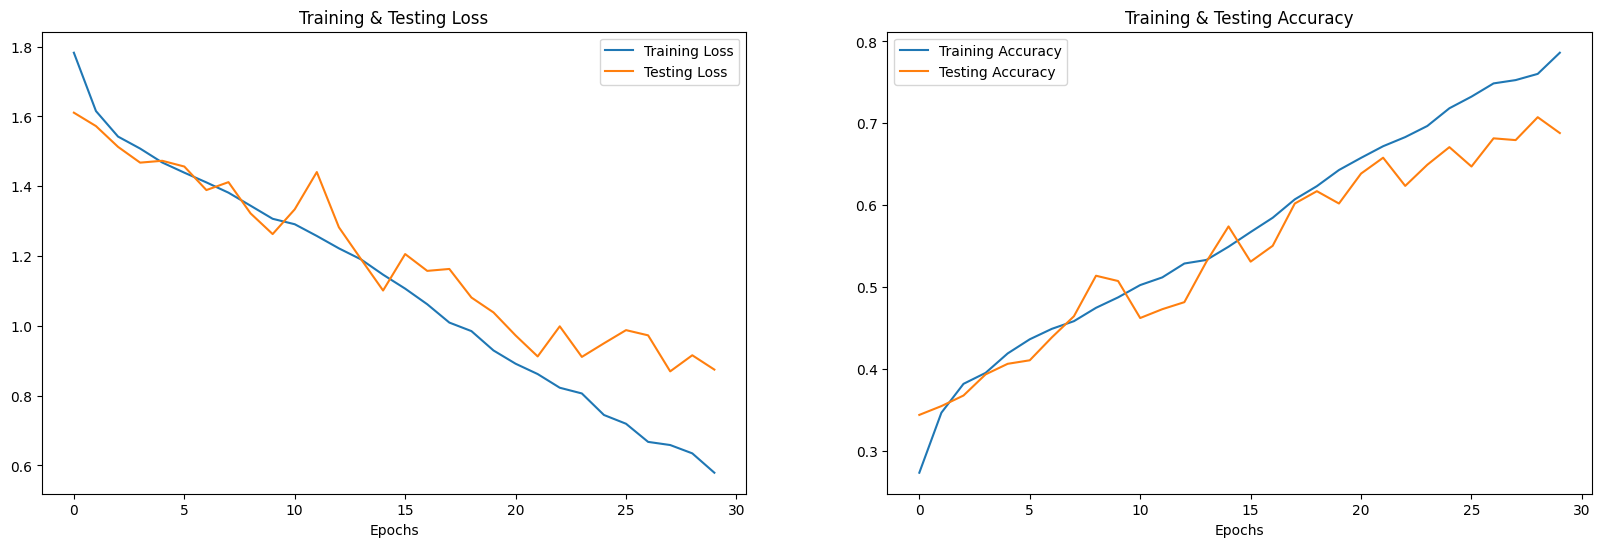

In [37]:
print_report(model, history, x_test, y_test)

In [38]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test_decoded = encoder.inverse_transform(y_test)

15/15 [==============================] - 1s 24ms/step


In [39]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test_decoded.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,fear,contempt
1,anger,anger
2,surprise,surprise
3,happiness,happiness
4,anger,fear
5,anger,anger
6,calm,calm
7,contempt,sadness
8,anger,anger
9,contempt,anger


In [40]:
def print_confusion_matrix(test, pred, size=(12, 10)):
    cm = confusion_matrix(test, pred)
    plt.figure(figsize=size)
    cm = pd.DataFrame(cm, index=[i for i in encoder.categories_], columns=[
        i for i in encoder.categories_])
    sns.heatmap(cm, linecolor='white', cmap='Blues',
                linewidth=1, annot=True, fmt='')
    plt.title('Confusion Matrix', size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)
    plt.show()


# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(12, 10))
# cm = pd.DataFrame(cm, index=[i for i in encoder.categories_], columns=[
#                   i for i in encoder.categories_])
# sns.heatmap(cm, linecolor='white', cmap='Blues',
#             linewidth=1, annot=True, fmt='')
# plt.title('Confusion Matrix', size=20)
# plt.xlabel('Predicted Labels', size=14)
# plt.ylabel('Actual Labels', size=14)
# plt.show()

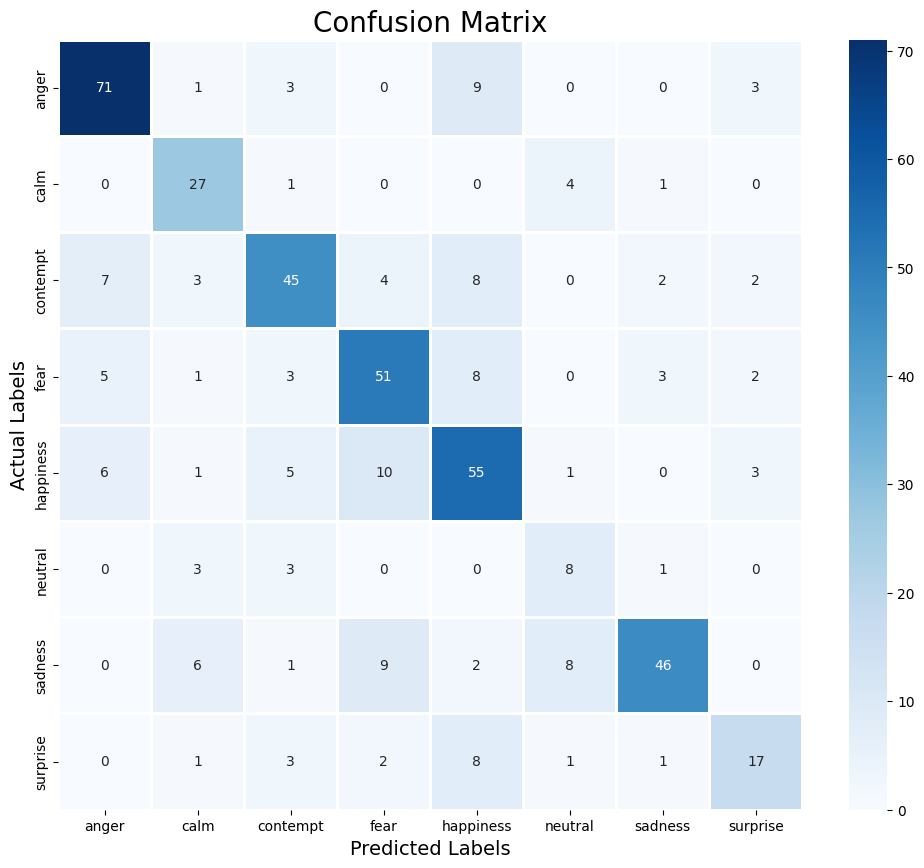

In [41]:
print_confusion_matrix(y_test_decoded, y_pred)

In [ ]:
print(classification_report(y_test_decoded, y_pred))

              precision    recall  f1-score   support

       anger       0.72      0.82      0.77        87
        calm       0.47      0.64      0.54        33
    contempt       0.54      0.37      0.44        71
        fear       0.36      0.44      0.40        73
   happiness       0.48      0.31      0.38        81
     neutral       0.50      0.07      0.12        15
     sadness       0.50      0.67      0.57        72
    surprise       0.39      0.42      0.41        33

    accuracy                           0.51       465
   macro avg       0.50      0.47      0.45       465
weighted avg       0.51      0.51      0.50       465



## Experiments

- use augmented data

- emofilm + emofilm_uk + ravdess


In [141]:
train_features, train_labels = get_features(train_df, augment=True)
test_features, test_labels = get_features(test_df, augment=False)
val_features, val_labels = get_features(val_df, augment=False)

train_labels = np.vstack(train_labels)
test_labels = np.vstack(test_labels)
val_labels = np.vstack(val_labels)

### model1

simple model,


In [67]:
input_shape = (128, 216, 3)
model1 = Sequential()
model1.add(Conv2D(
    32, (3, 3), activation='relu', input_shape=input_shape))
model1.add(MaxPooling2D((2, 2)))
model1.add(Flatten())
model1.add(Dense(32, activation='relu'))
model1.add(Dense(units=5, activation='softmax'))

model1.compile(optimizer='adam',
               loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 214, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 107, 32)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 215712)            0         
                                                                 
 dense_3 (Dense)             (None, 32)                6902816   
                                                                 
 dense_4 (Dense)             (None, 5)                 165       
                                                                 
Total params: 6,903,877
Trainable params: 6,903,877
Non-trainable params: 0
____________________________________________

In [68]:
history1 = model1.fit(train_features, train_labels, epochs=epochs_num,
                      validation_data=(val_features, y_val))

Epoch 1/10
74/74 [==============================] - 14s 186ms/step - loss: 1.5517 - accuracy: 0.4278 - val_loss: 1.5825 - val_accuracy: 0.3034
Epoch 2/10
74/74 [==============================] - 13s 175ms/step - loss: 0.5060 - accuracy: 0.8718 - val_loss: 1.5078 - val_accuracy: 0.4103
Epoch 3/10
74/74 [==============================] - 13s 175ms/step - loss: 0.0766 - accuracy: 0.9983 - val_loss: 1.6891 - val_accuracy: 0.4145
Epoch 4/10
74/74 [==============================] - 13s 180ms/step - loss: 0.0192 - accuracy: 1.0000 - val_loss: 1.8541 - val_accuracy: 0.4359
Epoch 5/10
74/74 [==============================] - 14s 185ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 1.9277 - val_accuracy: 0.4316
Epoch 6/10
74/74 [==============================] - 14s 184ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 2.0354 - val_accuracy: 0.4231
Epoch 7/10
74/74 [==============================] - 14s 186ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 2.0896 - val_accuracy: 0.4231

4/4 [==============================] - 0s 39ms/step - loss: 2.0161 - accuracy: 0.4653
Accuracy of our model on test data :  46.53465449810028 %


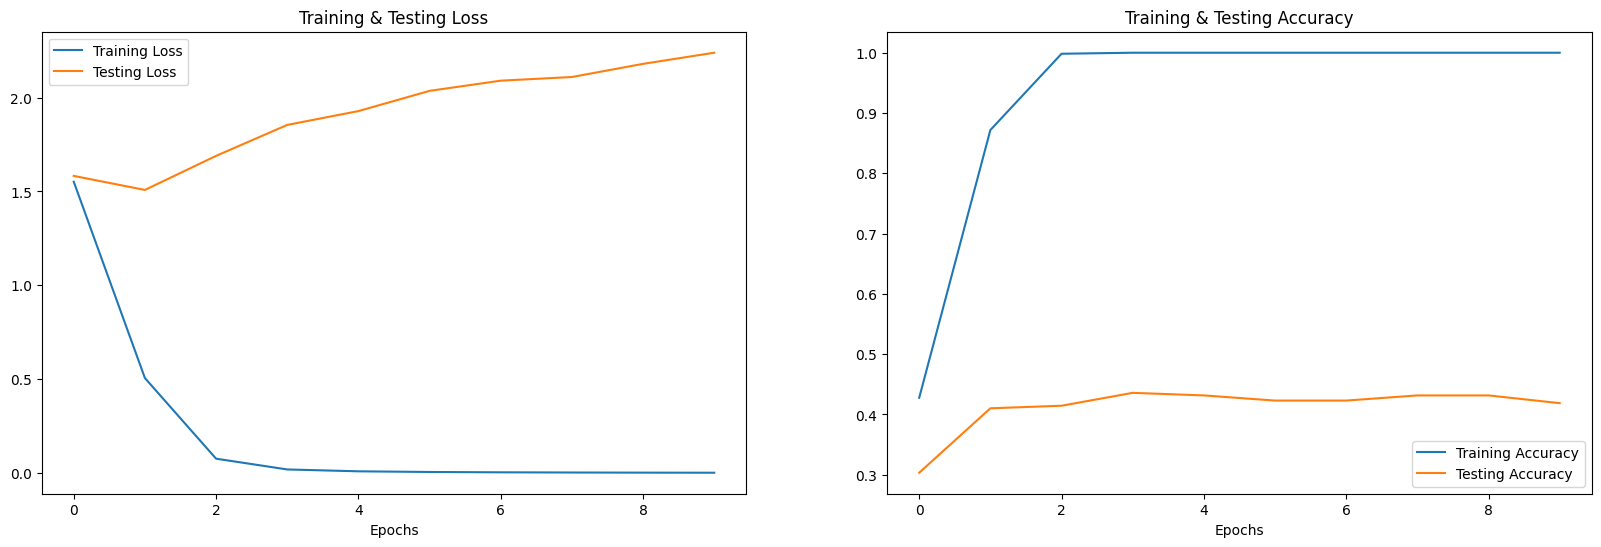

In [69]:
print_report(model1, history1, test_features, test_labels)

In [74]:
# predicting on test data.
pred_test = model1.predict(test_features)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

4/4 [==============================] - 0s 37ms/step


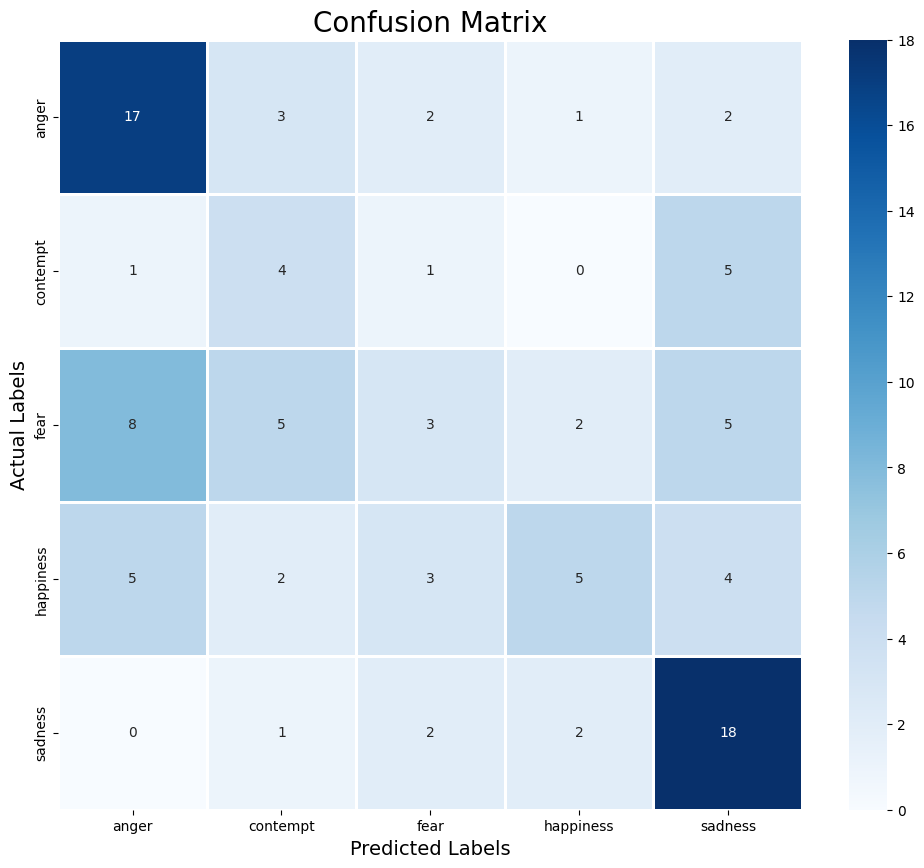

In [75]:
print_confusion_matrix(y_test, y_pred)

### model2

more complex model

slow increasing of conv2d filers number


In [81]:
# 128*216*3  # 82944 input number of parameters
# 125*213*3*32  # 2556000 first conv2d number of parameters

In [92]:
input_shape = (128, 216, 3)
model2 = Sequential()
model2.add(Conv2D(12, (3, 3), activation='relu', input_shape=input_shape))
model2.add(Conv2D(18, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.2))
model2.add(Conv2D(24, (3, 3), activation='relu'))
model2.add(Conv2D(23, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(32, activation='relu'))
model2.add(Dense(units=5, activation='softmax'))

model2.compile(optimizer='adam',
               loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 126, 214, 12)      336       
                                                                 
 conv2d_31 (Conv2D)          (None, 124, 212, 18)      1962      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 62, 106, 18)      0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 62, 106, 18)       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 60, 104, 24)       3912      
                                                                 
 conv2d_33 (Conv2D)          (None, 58, 102, 23)       4991      
                                                      

In [93]:
history2 = model2.fit(train_features, train_labels, epochs=epochs_num,
                      validation_data=(val_features, y_val))

Epoch 1/10
74/74 [==============================] - 37s 497ms/step - loss: 1.6045 - accuracy: 0.2444 - val_loss: 1.5796 - val_accuracy: 0.2265
Epoch 2/10
74/74 [==============================] - 37s 504ms/step - loss: 1.4082 - accuracy: 0.3855 - val_loss: 1.5252 - val_accuracy: 0.3846
Epoch 3/10
74/74 [==============================] - 38s 508ms/step - loss: 0.8782 - accuracy: 0.6427 - val_loss: 1.8954 - val_accuracy: 0.3846
Epoch 4/10
74/74 [==============================] - 38s 517ms/step - loss: 0.2706 - accuracy: 0.9064 - val_loss: 3.0197 - val_accuracy: 0.3333
Epoch 5/10
74/74 [==============================] - 40s 538ms/step - loss: 0.0675 - accuracy: 0.9778 - val_loss: 3.7017 - val_accuracy: 0.4145
Epoch 6/10
74/74 [==============================] - 43s 583ms/step - loss: 0.0185 - accuracy: 0.9966 - val_loss: 5.1481 - val_accuracy: 0.3846
Epoch 7/10
74/74 [==============================] - 39s 522ms/step - loss: 0.0119 - accuracy: 0.9974 - val_loss: 4.9572 - val_accuracy: 0.4231

4/4 [==============================] - 0s 72ms/step - loss: 4.6610 - accuracy: 0.4653
Accuracy of our model on test data :  46.53465449810028 %


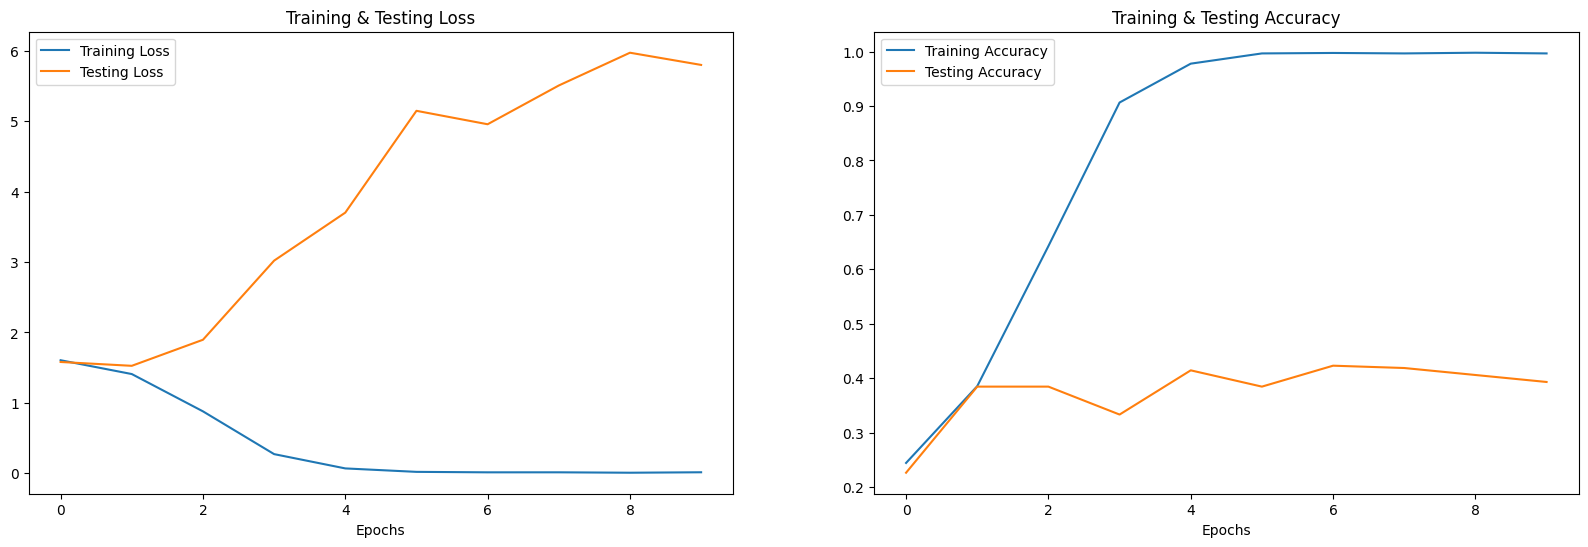

In [98]:
print_report(model2, history2, test_features, test_labels)

In [99]:
# predicting on test data.
pred_test = model2.predict(test_features)
y_pred = encoder.inverse_transform(pred_test)

4/4 [==============================] - 0s 79ms/step


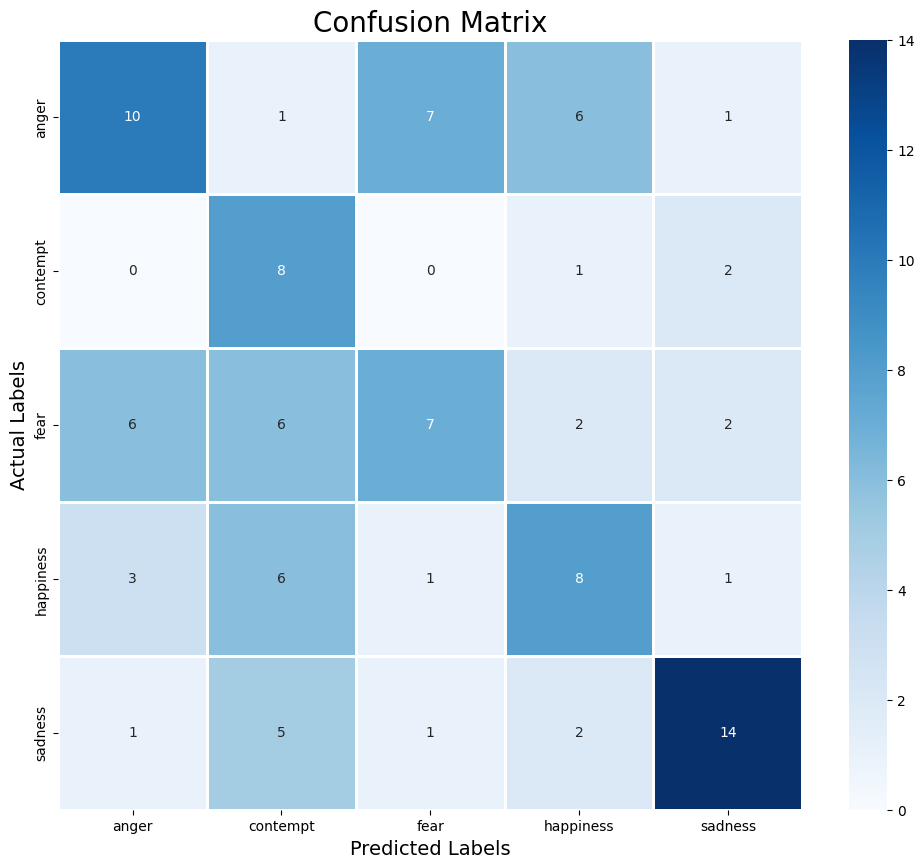

In [100]:
print_confusion_matrix(y_test, y_pred)

In [101]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.50      0.40      0.44        25
    contempt       0.31      0.73      0.43        11
        fear       0.44      0.30      0.36        23
   happiness       0.42      0.42      0.42        19
     sadness       0.70      0.61      0.65        23

    accuracy                           0.47       101
   macro avg       0.47      0.49      0.46       101
weighted avg       0.50      0.47      0.47       101



In [ ]:
# print_report(model, history, test_features, test_labels)
# # predicting on test data.
# pred_test = model.predict(test_features)
# y_pred = encoder.inverse_transform(pred_test)
# print_confusion_matrix(y_test, y_pred)
# print(classification_report(y_test, y_pred))

### model3

model2 a bit more complex


In [120]:
input_shape = (128, 216, 3)
model3 = Sequential()
model3.add(Conv2D(12, (5, 5), activation='relu', input_shape=input_shape))
model3.add(Conv2D(16, (5, 5), activation='relu'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.2))
model3.add(Conv2D(64, (5, 5), activation='relu'))
model3.add(MaxPooling2D((3, 3)))
model3.add(Dropout(0.2))
model3.add(Flatten())
model3.add(Dense(32, activation='relu'))
model3.add(Dense(16, activation='relu'))
model3.add(Dense(units=5, activation='softmax'))

model3.compile(optimizer='adam',
               loss='categorical_crossentropy', metrics=['accuracy'])

model3.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_81 (Conv2D)          (None, 124, 212, 12)      912       
                                                                 
 conv2d_82 (Conv2D)          (None, 120, 208, 16)      4816      
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 60, 104, 16)      0         
 g2D)                                                            
                                                                 
 dropout_36 (Dropout)        (None, 60, 104, 16)       0         
                                                                 
 conv2d_83 (Conv2D)          (None, 56, 100, 64)       25664     
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 18, 33, 64)       0         
 g2D)                                                

In [121]:
history3 = model3.fit(train_features, train_labels, epochs=epochs_num,
                      validation_data=(val_features, y_val))

Epoch 1/10
74/74 [==============================] - 70s 935ms/step - loss: 1.6128 - accuracy: 0.2226 - val_loss: 1.5977 - val_accuracy: 0.2179
Epoch 2/10
74/74 [==============================] - 82s 1s/step - loss: 1.4949 - accuracy: 0.3410 - val_loss: 1.7943 - val_accuracy: 0.2906
Epoch 3/10
74/74 [==============================] - 71s 958ms/step - loss: 1.0550 - accuracy: 0.5868 - val_loss: 1.4317 - val_accuracy: 0.4188
Epoch 4/10
74/74 [==============================] - 70s 941ms/step - loss: 0.5523 - accuracy: 0.7880 - val_loss: 1.8271 - val_accuracy: 0.4274
Epoch 5/10
74/74 [==============================] - 70s 941ms/step - loss: 0.1645 - accuracy: 0.9453 - val_loss: 2.5896 - val_accuracy: 0.4615
Epoch 6/10
74/74 [==============================] - 457s 6s/step - loss: 0.0475 - accuracy: 0.9876 - val_loss: 3.3279 - val_accuracy: 0.4786
Epoch 7/10
74/74 [==============================] - 63s 847ms/step - loss: 0.0274 - accuracy: 0.9932 - val_loss: 3.6789 - val_accuracy: 0.4487
Epoc

4/4 [==============================] - 0s 75ms/step - loss: 4.3294 - accuracy: 0.3960
Accuracy of our model on test data :  39.6039605140686 %


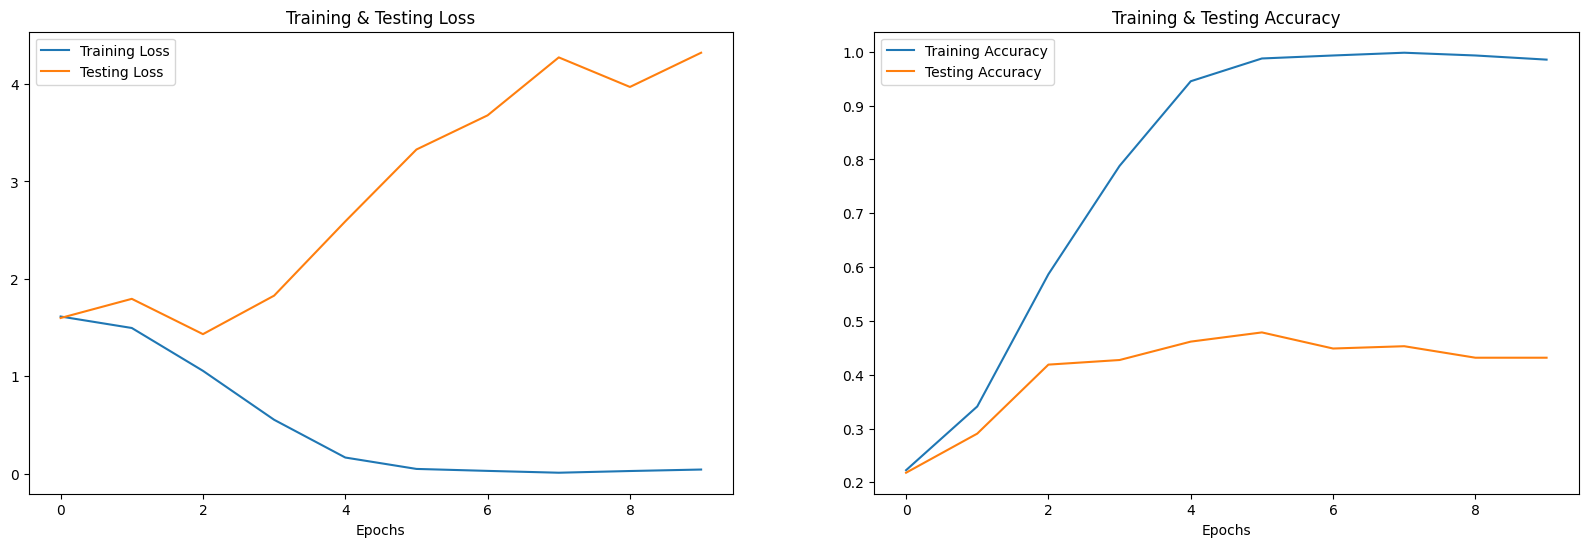

In [122]:
print_report(model3, history3, test_features, test_labels)

In [123]:
# predicting on test data.
pred_test = model3.predict(test_features)
y_pred = encoder.inverse_transform(pred_test)

4/4 [==============================] - 0s 73ms/step


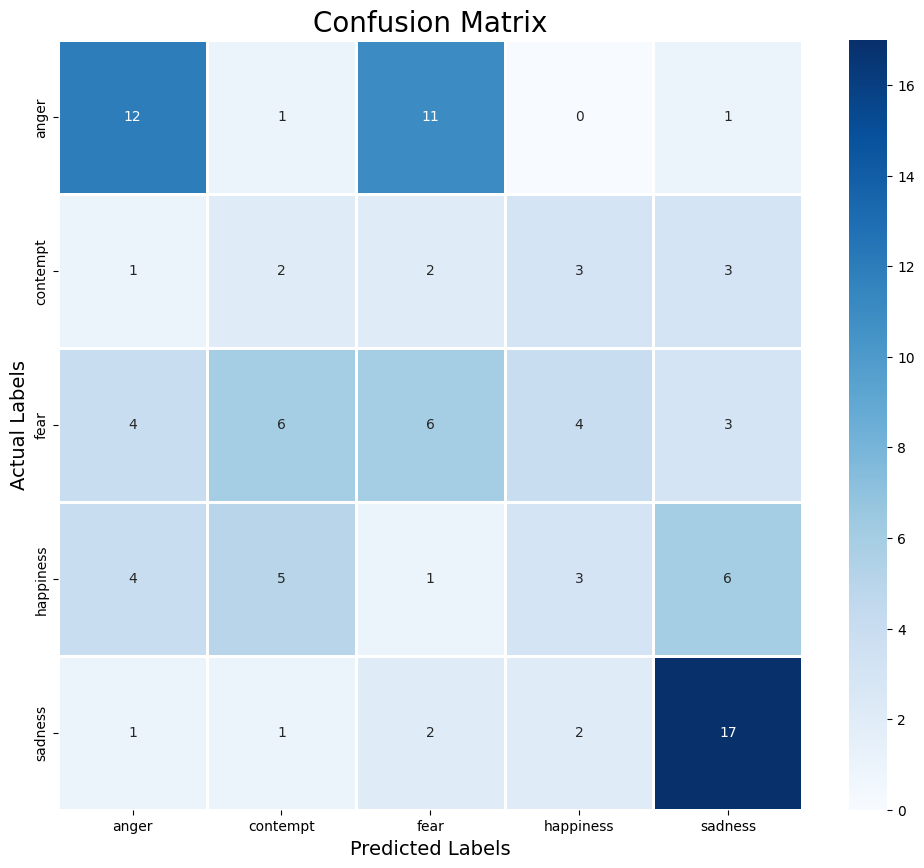

              precision    recall  f1-score   support

       anger       0.55      0.48      0.51        25
    contempt       0.13      0.18      0.15        11
        fear       0.27      0.26      0.27        23
   happiness       0.25      0.16      0.19        19
     sadness       0.57      0.74      0.64        23

    accuracy                           0.40       101
   macro avg       0.35      0.36      0.35       101
weighted avg       0.39      0.40      0.39       101



In [124]:
print_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

### model4

model3 a bit more complex


In [63]:
input_shape = (128, 216, 3)
model4 = Sequential()
model4.add(Conv2D(12, (5, 5), activation='relu', input_shape=input_shape))
model4.add(Conv2D(16, (5, 5), activation='relu'))
model4.add(MaxPooling2D((2, 2)))
model4.add(Dropout(0.2))
model4.add(Conv2D(32, (5, 5), activation='relu'))
model4.add(MaxPooling2D((2, 2)))
model4.add(Dropout(0.2))
model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dense(64, activation='relu'))
model4.add(Dense(32, activation='relu'))
model4.add(Dense(16, activation='relu'))
model4.add(Dense(units=5, activation='softmax'))

model4.compile(optimizer='adam',
               loss='categorical_crossentropy', metrics=['accuracy'])

model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 124, 212, 12)      912       
                                                                 
 conv2d_4 (Conv2D)           (None, 120, 208, 16)      4816      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 104, 16)      0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 60, 104, 16)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 100, 32)       12832     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 28, 50, 32)       0         
 2D)                                                  

In [ ]:
history4 = model4.fit(train_features, train_labels, epochs=epochs_num,
                      validation_data=(val_features, y_val))

Epoch 1/10
74/74 [==============================] - 54s 723ms/step - loss: 1.6070 - accuracy: 0.2222 - val_loss: 1.6049 - val_accuracy: 0.2179
Epoch 2/10
74/74 [==============================] - 54s 734ms/step - loss: 1.4776 - accuracy: 0.3538 - val_loss: 1.4962 - val_accuracy: 0.3547
Epoch 3/10
74/74 [==============================] - 54s 735ms/step - loss: 0.8937 - accuracy: 0.6560 - val_loss: 1.7666 - val_accuracy: 0.4145
Epoch 4/10
74/74 [==============================] - 55s 742ms/step - loss: 0.2058 - accuracy: 0.9321 - val_loss: 2.8004 - val_accuracy: 0.3974
Epoch 5/10
74/74 [==============================] - 55s 746ms/step - loss: 0.0399 - accuracy: 0.9885 - val_loss: 3.7266 - val_accuracy: 0.3761
Epoch 6/10
74/74 [==============================] - 56s 753ms/step - loss: 0.0160 - accuracy: 0.9957 - val_loss: 4.5154 - val_accuracy: 0.4017
Epoch 7/10
74/74 [==============================] - 56s 760ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 4.7498 - val_accuracy: 0.4060

4/4 [==============================] - 0s 73ms/step - loss: 4.4314 - accuracy: 0.3564
Accuracy of our model on test data :  35.64356565475464 %


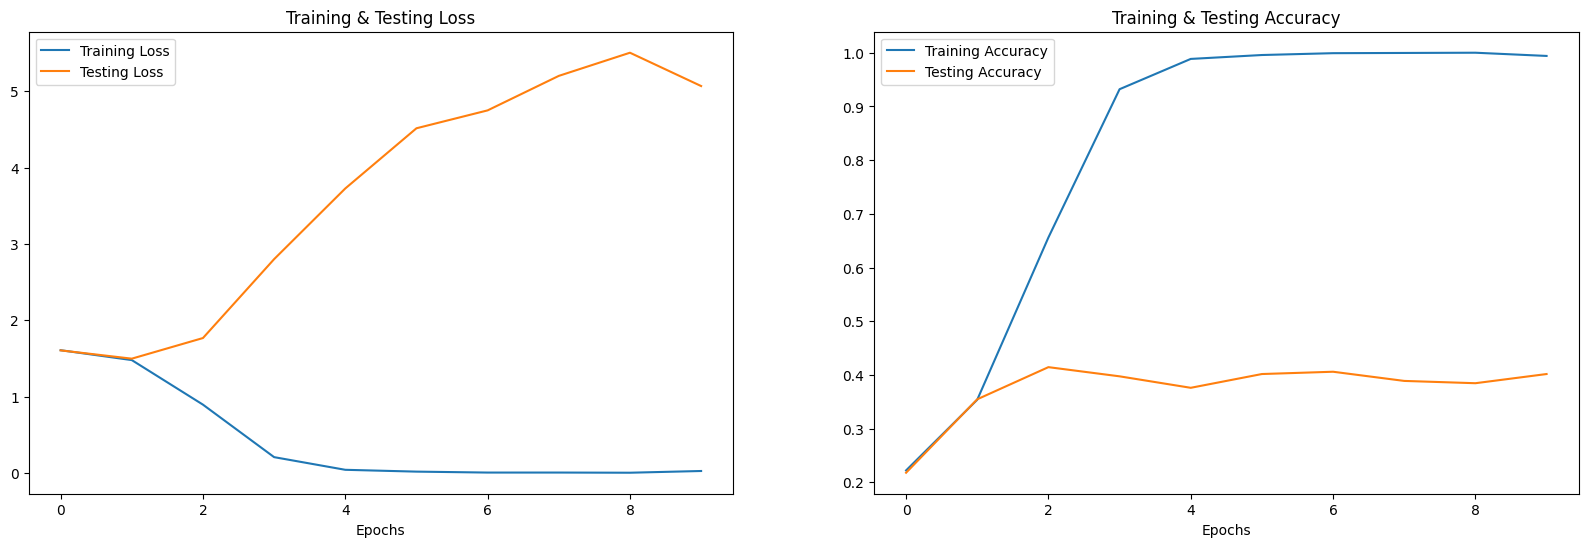

In [ ]:
print_report(model4, history4, test_features, test_labels)

In [ ]:
# predicting on test data.
pred_test = model4.predict(test_features)
y_pred = encoder.inverse_transform(pred_test)

4/4 [==============================] - 0s 79ms/step


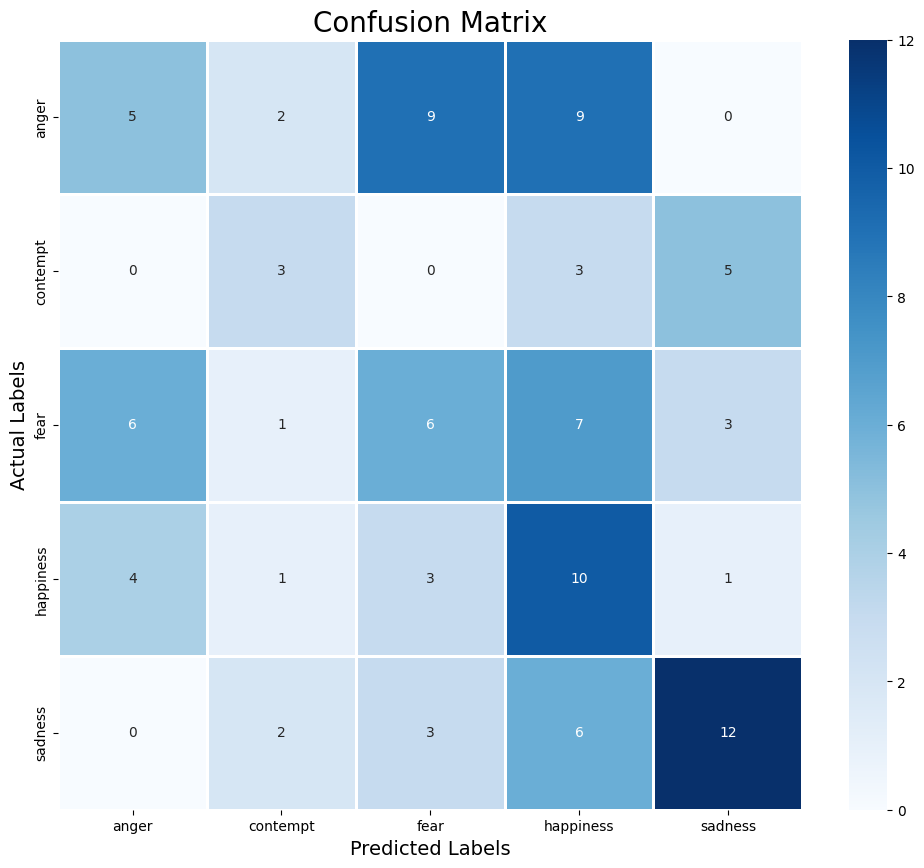

              precision    recall  f1-score   support

       anger       0.33      0.20      0.25        25
    contempt       0.33      0.27      0.30        11
        fear       0.29      0.26      0.27        23
   happiness       0.29      0.53      0.37        19
     sadness       0.57      0.52      0.55        23

    accuracy                           0.36       101
   macro avg       0.36      0.36      0.35       101
weighted avg       0.37      0.36      0.35       101



In [ ]:
print_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

### Model 5


In [142]:
input_shape = (128, 216, 3)
model5 = Sequential()
model5.add(Conv2D(12, (5, 5), activation='relu',
           input_shape=input_shape, padding='same'))
model5.add(Conv2D(16, (5, 5), activation='relu', padding='same'))
model5.add(MaxPooling2D((2, 2)))
model5.add(Dropout(0.3))
model5.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model5.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model5.add(MaxPooling2D((2, 2)))
model5.add(Dropout(0.3))
model5.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model5.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model5.add(MaxPooling2D((2, 2)))
model5.add(Dropout(0.3))
model5.add(Flatten())
model5.add(Dense(64, activation='relu'))
model5.add(Dense(32, activation='relu'))
model5.add(Dense(16, activation='relu'))
model5.add(Dense(units=emotions_number, activation='softmax'))


initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

adam = tf.optimizers.Adam(
    learning_rate=0.001
)
model5.compile(optimizer=adam,
               loss='categorical_crossentropy', metrics=['accuracy'])

model5.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 128, 216, 12)      912       
                                                                 
 conv2d_59 (Conv2D)          (None, 128, 216, 16)      4816      
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 64, 108, 16)      0         
 g2D)                                                            
                                                                 
 dropout_31 (Dropout)        (None, 64, 108, 16)       0         
                                                                 
 conv2d_60 (Conv2D)          (None, 64, 108, 32)       4640      
                                                                 
 conv2d_61 (Conv2D)          (None, 64, 108, 32)       9248      
                                                     

In [143]:
history5 = model5.fit(train_features, train_labels, epochs=5,
                      validation_data=(val_features, y_val))

Epoch 1/5
117/170 [===================>..........] - ETA: 1:08 - loss: 1.9493 - accuracy: 0.1728

KeyboardInterrupt: 

4/4 [==============================] - 0s 91ms/step - loss: 3.9095 - accuracy: 0.3107
Accuracy of our model on test data :  31.06796145439148 %


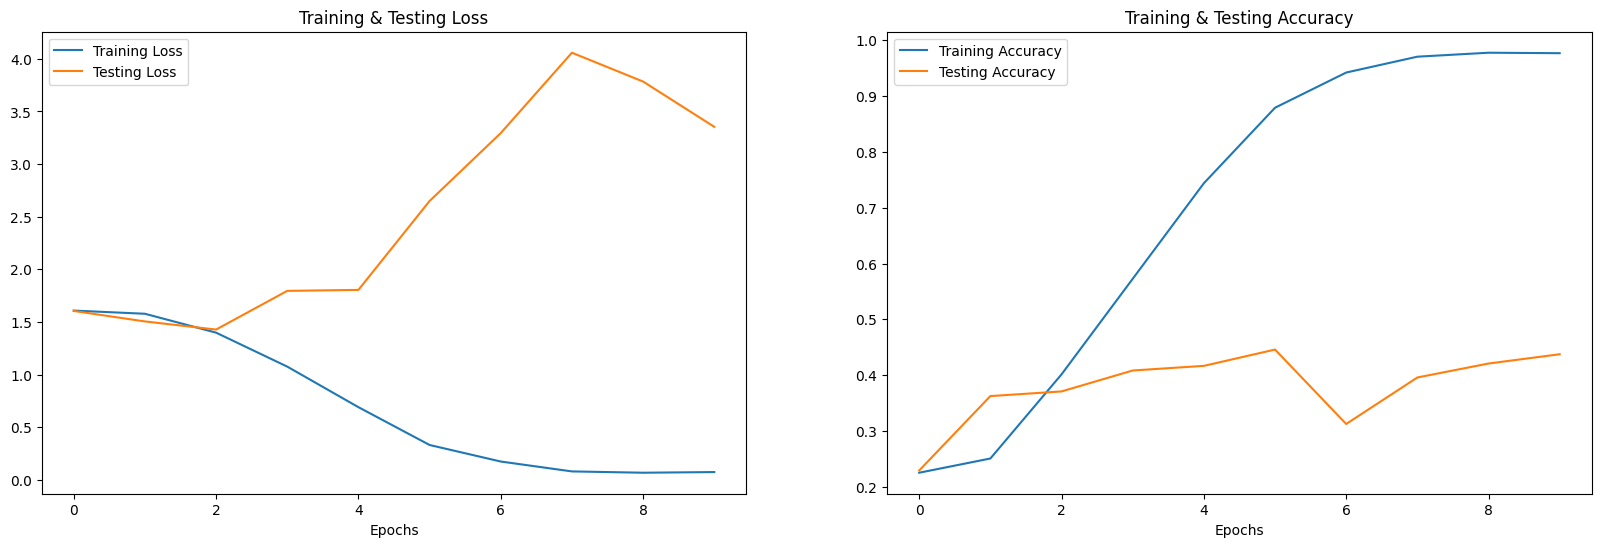

In [ ]:
print_report(model5, history5, test_features, test_labels)

In [ ]:

y_test = encoder.inverse_transform(y_test)

ValueError: could not convert string to float: 'contempt'

In [ ]:
# predicting on test data.
pred_test = model5.predict(test_features)
y_pred = encoder.inverse_transform(pred_test)

4/4 [==============================] - 0s 80ms/step


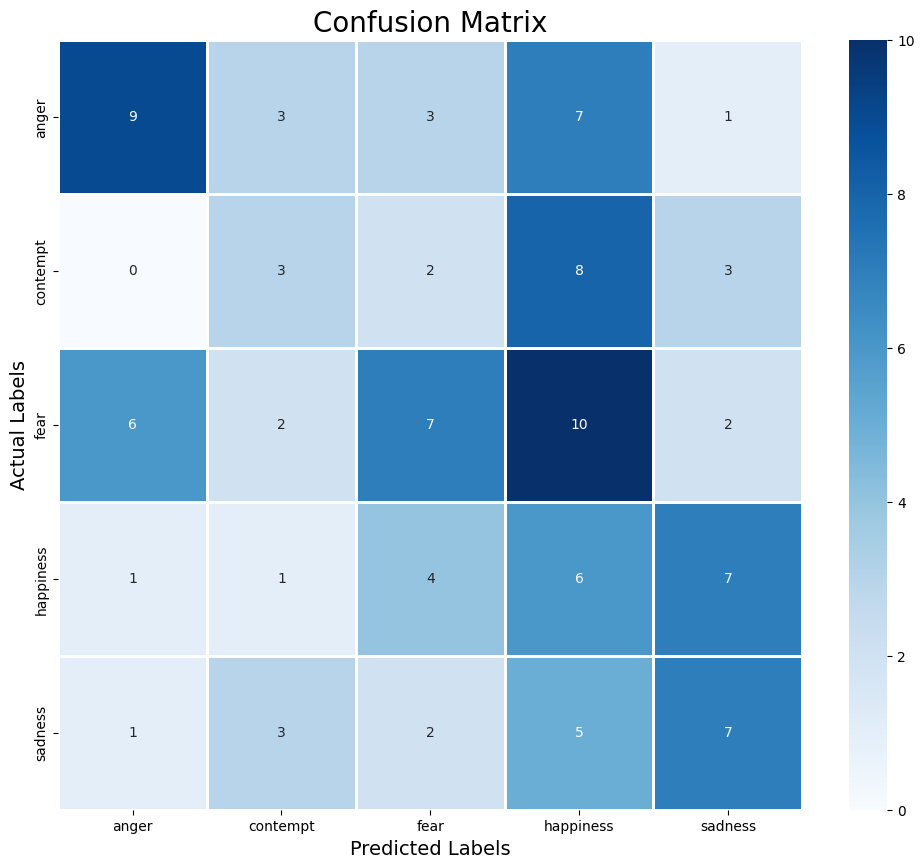

              precision    recall  f1-score   support

       anger       0.53      0.39      0.45        23
    contempt       0.25      0.19      0.21        16
        fear       0.39      0.26      0.31        27
   happiness       0.17      0.32      0.22        19
     sadness       0.35      0.39      0.37        18

    accuracy                           0.31       103
   macro avg       0.34      0.31      0.31       103
weighted avg       0.35      0.31      0.32       103



In [ ]:
print_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

## Stuff


get features -- old


In [134]:
spec_bw = librosa.feature.spectral_bandwidth(y=padded_audio, sr=sr)
spec_centroid = librosa.feature.spectral_centroid(y=padded_audio, sr=sr)
chroma_stft = librosa.feature.chroma_stft(y=padded_audio, sr=sr)
zcr = extract_zcr(data=padded_audio)
rms = extract_rms(data=padded_audio)

stft = np.abs(librosa.stft(padded_audio, n_fft=255, hop_length=512))
MFCCs = librosa.feature.mfcc(
    y=padded_audio, hop_length=hop_length, n_mfcc=height)
mels = extract_melspectrogram(data=padded_audio, sr=sr)

print(spec_bw.shape, spec_centroid.shape,
      chroma_stft.shape, zcr.shape, rms.shape, stft.shape, MFCCs.shape, mels.shape)

(1, 216) (1, 216) (12, 216) (1, 216) (1, 216) (128, 216) (128, 216) (128, 216)


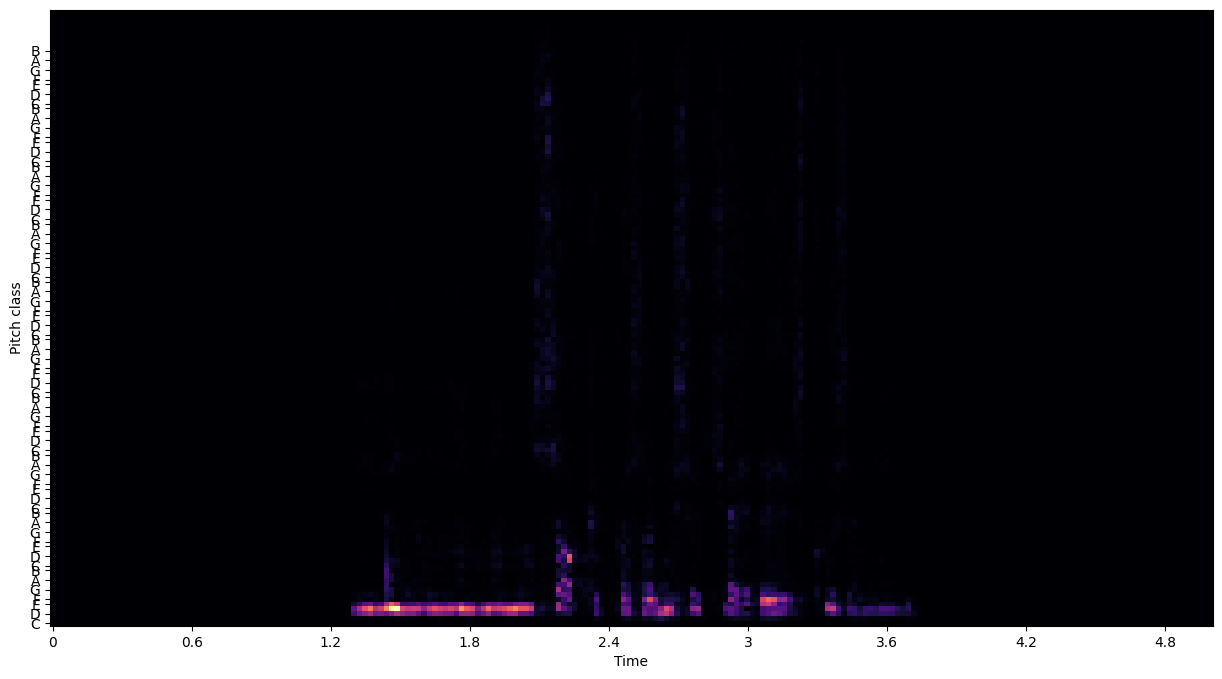

In [135]:
plt.figure(figsize=(15, 8))
librosa.display.specshow(stft, x_axis='time',
                         y_axis='chroma', hop_length=512)
plt.show()

add padding to features -- skip (use padded audio to extract features in first place)


In [136]:
# spec_bw = padding(spec_bw, 1, width)
# spec_centroid = padding(spec_centroid, 1, width)
# chroma_stft = padding(chroma_stft, 1, width)
# zcr = padding(zcr, 1, width)
# rms = padding(rms, 1, width)

# stft = padding(stft, height, width)
# MFCCs = padding(MFCCs, height, width)
# mels = padding(mels, height, width)


# print(spec_bw.shape, spec_centroid.shape,
#       chroma_stft.shape, zcr.shape, rms.shape, stft.shape, MFCCs.shape, mels.shape)

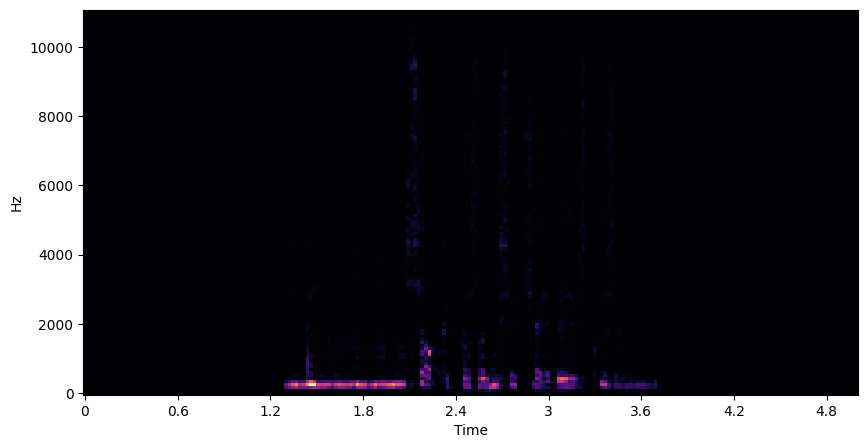

In [137]:
plt.figure(figsize=(10, 5))
librosa.display.specshow(stft, x_axis='time',
                         y_axis='linear', hop_length=512)
plt.show()

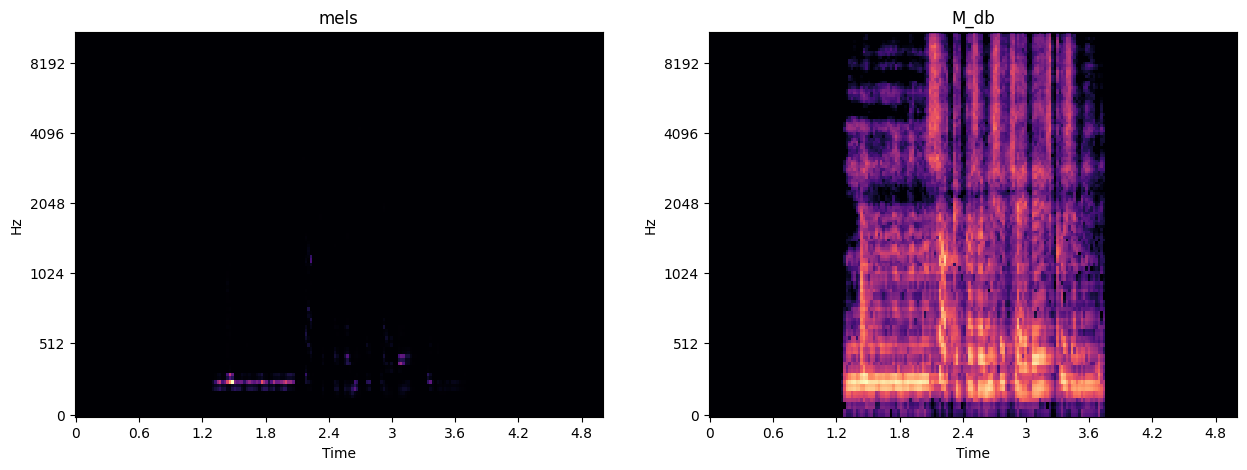

In [138]:
M_db = librosa.power_to_db(mels, ref=np.max)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# plt.figure(figsize=(10, 5))

librosa.display.specshow(mels, x_axis='time', ax=ax1,
                         y_axis='mel', hop_length=512)
librosa.display.specshow(M_db, x_axis='time', ax=ax2,
                         y_axis='mel', hop_length=512)
ax1.set_title('mels')
ax2.set_title('M_db')
plt.show()

combine features into image with 3 layers


128 / 16 = 8 -> features 8 times to match mfccs and features height


In [139]:
print(spec_bw.shape, spec_centroid.shape,
      chroma_stft.shape, zcr.shape, rms.shape)

image_width = spec_bw.shape[1]
print(width, width2, image_width)

(1, 216) (1, 216) (12, 216) (1, 216) (1, 216)
216 110250 216


In [140]:
image = np.zeros((0, 216))

for i in range(0, 8):
    image = np.append(image, padding(
        normalize(spec_bw), 1, image_width), axis=0)
    image = np.append(image, padding(
        normalize(spec_centroid), 1, image_width), axis=0)
    image = np.append(image, padding(
        normalize(zcr), 1, image_width), axis=0)
    image = np.append(image, padding(
        normalize(rms), 1, image_width), axis=0)
    image = np.append(image, padding(
        normalize(chroma_stft), 12, image_width), axis=0)

image.shape

(128, 216)

In [141]:
image

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

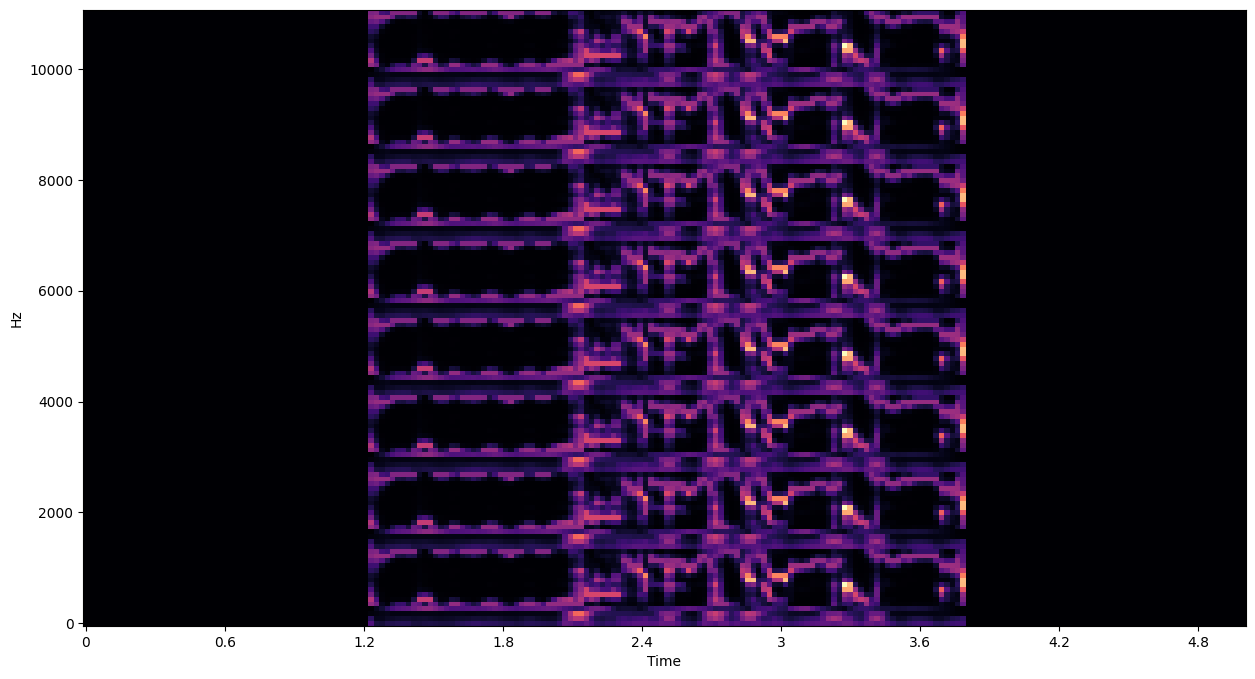

In [142]:
plt.figure(figsize=(15, 8))
librosa.display.specshow(image, x_axis='time',
                         y_axis='linear', hop_length=512)
plt.show()

Combine into single image


In [143]:
stft_n = padding(
    normalize(stft), 128, image_width)

MFCCs_n = padding(
    normalize(MFCCs), 128, image_width)

image = np.dstack((image, stft_n))
image = np.dstack((image, MFCCs_n))

In [144]:
# image = np.dstack((image, stft))
# image = np.dstack((image, MFCCs))

In [145]:
image.shape

(128, 216, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


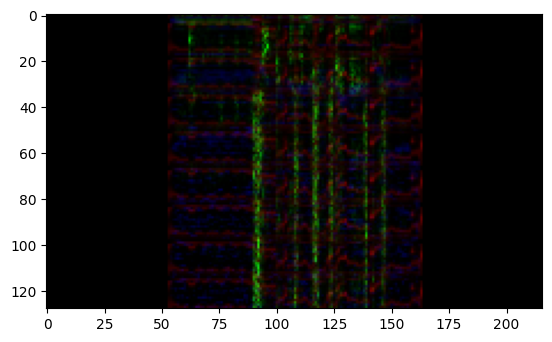

In [146]:
plt.imshow(image)

Something else...


In [147]:
image = np.array([padding(normalize(spec_bw), 1, 200)]).reshape(1, width)

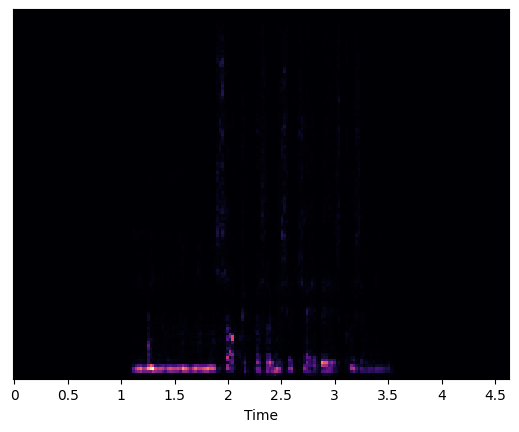

In [148]:
stft = padding(
    np.abs(librosa.stft(a, n_fft=255, hop_length=512)), 128, 200)
librosa.display.specshow(stft, sr=sr, x_axis='time')

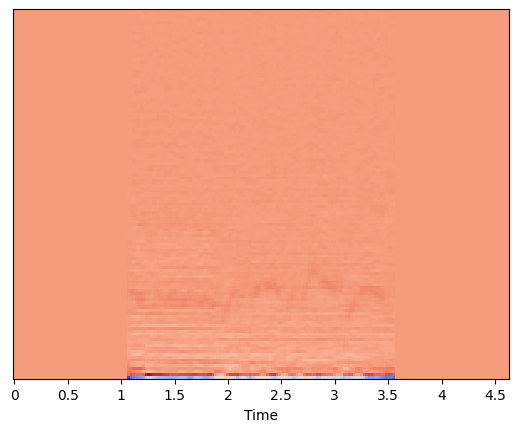

In [149]:
MFCCs = padding(librosa.feature.mfcc(y=a,
                                     hop_length=hop_length, n_mfcc=128), 128, 200)
librosa.display.specshow(MFCCs, sr=sr, x_axis='time')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


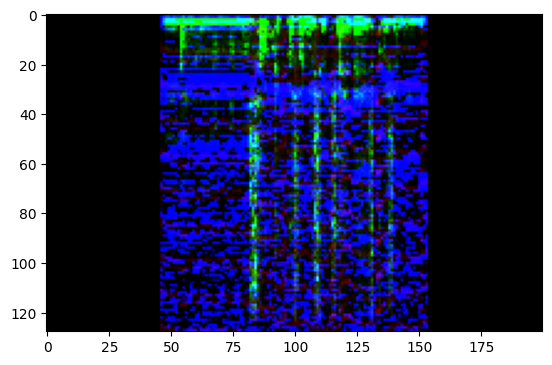

In [150]:
test = generate_features(a)
plt.imshow(test)

In [151]:
# X, Y = [], []
# for path, emotion in zip(data_df.path, data_df.emotion):
#     features = get_features(path)
#     for ele in features:
#         X.append(ele)
#         Y.append(emotion)

# Features = pd.DataFrame(X)
# Features['labels'] = Y
# # Features.to_csv('features.csv', index=False)
# Features.head()